# CAPSTON PROJECT

---



## STEP 1: LOAD and IMPORT LIBRARIES

---



In [1]:
import os
import pandas as pd
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import HashingTF
import re

## STEP 2: IMPORT DATA

---



In [2]:
dataset_df = pd.read_csv("Resources/fake_job_postings.csv")
dataset_df.head(6)

#import psycopg2
#import getpass
#db_password = getpass.getpass(prompt='DB Password ')

#engine = psycopg2.connect(
#    database="Capstone_Project_Group_9",
#    user="postgres",
#    password=db_password,
#    host="capstone-project-group-9.c4857qrbkptn.us-east-2.rds.amazonaws.com",
#    port='5432'
#)

#dataset_df = pd.read_sql('SELECT * FROM Test', engine)
#dataset_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US; NY; New York,Marketing,NaN,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,NZ; ; Auckland,Success,NaN,90 Seconds the worlds Cloud Video Production S...,Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),US; IA; Wever,NaN,NaN,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively seek...,Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,US; DC; Washington,Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,EDUCATION: Bachelor’s or Master’s in GIS busin...,Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,US; FL; Fort Worth,NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,US; MD;,NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0


In [3]:
# Drop columns with too many null values or where all values are unique
dataset_df = dataset_df.drop(columns=['job_id','salary_range','title'])

In [4]:
# Display number of null values ofr each column
dataset_df.isnull().sum()

location                 346
department             11547
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
# Split the location columns by the seperator and only keep the country, state and city
# THe split method was kept in the event it it necessary to adapt the code to keep the state and city
location_split = dataset_df['location'].str.split(';', n=2, expand=True)
dataset_df = dataset_df.join(location_split[0])
dataset_df.rename(columns={0: "Country"},inplace=True)
dataset_df = dataset_df.drop(columns=['location'])
dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US


In [6]:
# Process to remove all characters from the data
clean_cols = ["company_profile", "description", "requirements", "benefits"]
str_cols = dataset_df.select_dtypes(['object'])

# Loop through clean_cols and apply character removal to each column
for col in clean_cols:
  dataset_df[col] = dataset_df[col].replace(r'[^a-zA-Z0-9\s]', '',regex=True)
  dataset_df[col] = dataset_df[col].replace(r'\s{2,}', '',regex=True)

dataset_df.head(6)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,Were Food52 and weve created a groundbreaking ...,Food52 a fastgrowing James Beard Awardwinning ...,Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US
1,Success,90 Seconds the worlds Cloud Video Production S...,OrganisedFocusedVibrantAwesomeDo you have a pa...,What we expect from youYour key responsibility...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,NaN,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively seek...,Implement precommissioning and commissioning p...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US
3,Sales,Our passion for improving quality of life thro...,THE COMPANY ESRIEnvironmental Systems Research...,EDUCATION Bachelors or Masters in GIS business...,Our culture is anything but corporatewe have a...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION F...,QUALIFICATIONSRN license in the State of Texas...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
5,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,US


In [7]:
# Replace null values with string "none"
dataset_df = dataset_df.fillna("none")
dataset_df.head()

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,Were Food52 and weve created a groundbreaking ...,Food52 a fastgrowing James Beard Awardwinning ...,Experience with content management systems a m...,none,0,1,0,Other,Internship,none,none,Marketing,0,US
1,Success,90 Seconds the worlds Cloud Video Production S...,OrganisedFocusedVibrantAwesomeDo you have a pa...,What we expect from youYour key responsibility...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,none,Marketing and Advertising,Customer Service,0,NZ
2,none,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively seek...,Implement precommissioning and commissioning p...,none,0,1,0,none,none,none,none,none,0,US
3,Sales,Our passion for improving quality of life thro...,THE COMPANY ESRIEnvironmental Systems Research...,EDUCATION Bachelors or Masters in GIS business...,Our culture is anything but corporatewe have a...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,none,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION F...,QUALIFICATIONSRN license in the State of Texas...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [8]:
# list dtypes for analysis
dataset_df.dtypes

department             object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
Country                object
dtype: object

In [9]:
# check the number of null values in columns
dataset_df.isnull().sum()

department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
dtype: int64

In [10]:
# Remove any whitespace from the country, city and state columns
# City and state is kept but commented out in the event the code needs to be adapted to keep city and state

#dataset_df['City'] = dataset_df['City'].map(lambda x: x.strip())
#dataset_df['State'] = dataset_df['State'].map(lambda x: x.strip())
dataset_df['Country'] = dataset_df['Country'].map(lambda x: x.strip())

#dataset_df['City'] = dataset_df['City'].replace('','none')
#dataset_df['State'] = dataset_df['State'].replace('','none')
dataset_df['Country'] = dataset_df['Country'].replace('','none')

#dataset_df.head()

In [11]:
# make all text lower case
string_cols = list(dataset_df.select_dtypes(include='object'))
for col in string_cols:
    dataset_df[col] = dataset_df[col].str.lower()

#dataset_df.head()

In [12]:
# Temporary code block to write cleaned data to csv at this point
#dataset_df.to_csv('/content/drive/MyDrive/Colab Notebooks/fake_job_postings_cleaned.csv')

In [13]:
# Get number of unique values in each column
dataset_df.nunique()

department              1284
company_profile         1710
description            14727
requirements           11909
benefits                6021
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
Country                   91
dtype: int64

## Step 3: Value Bucketing

---



In [14]:
# Define function that will keep the top n number of values in a column and change the rest to other
def top_n_values(df_column, n):
  df_column_counts = df_column.value_counts()
  replace_df_column = list(df_column_counts[n:].index)

  # Replace in DataFrame
  for val in replace_df_column:
    df_column = df_column.replace(val,"Other")

  return df_column

In [15]:
dataset_df['department'] = top_n_values(dataset_df['department'], 10)
dataset_df.department.value_counts()

none                      11547
Other                      3938
sales                       568
engineering                 494
marketing                   403
operations                  271
it                          226
development                 146
product                     114
information technology       87
customer service             86
Name: department, dtype: int64

In [16]:
dataset_df['industry'] = top_n_values(dataset_df['industry'], 10)
dataset_df.industry.value_counts()

Other                                  5179
none                                   4903
information technology and services    1734
computer software                      1376
internet                               1062
marketing and advertising               828
education management                    822
financial services                      779
hospital & health care                  497
consumer services                       358
telecommunications                      342
Name: industry, dtype: int64

In [17]:
dataset_df['function'] = top_n_values(dataset_df['function'], 10)
dataset_df.function.value_counts()

none                      6455
Other                     3168
information technology    1749
sales                     1468
engineering               1348
customer service          1229
marketing                  830
administrative             630
design                     340
health care provider       338
other                      325
Name: function, dtype: int64

In [18]:
dataset_df['Country'] = top_n_values(dataset_df['Country'], 10)
dataset_df.Country.value_counts()

us       10656
gb        2384
Other     1759
gr         940
ca         457
de         383
none       346
nz         333
in         276
au         214
ph         132
Name: Country, dtype: int64

In [19]:
## required_education
# combine education values that are not formal education
required_education_vals = ['Vocational', 'Vocational - HS Diploma', 'Vocational - Degree', 'Professional', 'Some High School Coursework', 'Some College Coursework Completed']
dataset_df.loc[(dataset_df['required_education'].isin(required_education_vals), 'required_education')] = 'other'

dataset_df.required_education.value_counts()

none                                 8105
bachelor's degree                    5145
high school or equivalent            2080
unspecified                          1397
master's degree                       416
associate degree                      274
certification                         170
some college coursework completed     102
professional                           74
vocational                             49
some high school coursework            27
doctorate                              26
vocational - hs diploma                 9
vocational - degree                     6
Name: required_education, dtype: int64

In [20]:
##Employment_Type
# Determine which values to replace
counts = dataset_df.employment_type.value_counts()
replace_employment_type = list(counts[counts < 1000].index)

# Replace in DataFrame
for val in replace_employment_type:
    dataset_df.employment_type = dataset_df.employment_type.replace(val,"Other")


# Check to make sure binning was successful
dataset_df.employment_type.value_counts()

full-time    11620
none          3471
contract      1524
Other         1265
Name: employment_type, dtype: int64

In [21]:
dataset_df.dtypes

department             object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
Country                object
dtype: object

## Exploratory for bucketing

---



In [22]:
# Exploration start
# Print out the Country value counts
print("Total number of rows")
print(len(dataset_df.index))
print(f'================')
print(f' ')

counts = dataset_df.department.value_counts()
print(f'counts for department')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.employment_type.value_counts()
print(f'counts for employment_type')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.required_experience.value_counts()
print(f'counts for required_experience')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.required_education.value_counts()
print(f'counts for required_education')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.industry.value_counts()
print(f'counts for industry')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.function.value_counts()
print(f'counts for function')
print(counts)
print(f'================')
print(f' ')

counts = dataset_df.Country.value_counts()
print(f'counts for Country')
print(counts)
print(f'================')
print(f' ')

#counts = dataset_df.State.value_counts()
#print(f'counts for State')
#print(counts)
#print(f'================')
#print(f' ')

#counts = dataset_df.City.value_counts()
#print(f'counts for City')
#print(counts)
#print(f'================')
#print(f' ')

Total number of rows
17880
 
counts for department
none                      11547
Other                      3938
sales                       568
engineering                 494
marketing                   403
operations                  271
it                          226
development                 146
product                     114
information technology       87
customer service             86
Name: department, dtype: int64
 
counts for employment_type
full-time    11620
none          3471
contract      1524
Other         1265
Name: employment_type, dtype: int64
 
counts for required_experience
none                7050
mid-senior level    3809
entry level         2697
associate           2297
not applicable      1116
director             389
internship           381
executive            141
Name: required_experience, dtype: int64
 
counts for required_education
none                                 8105
bachelor's degree                    5145
high school or equivalent           

<AxesSubplot:ylabel='Density'>

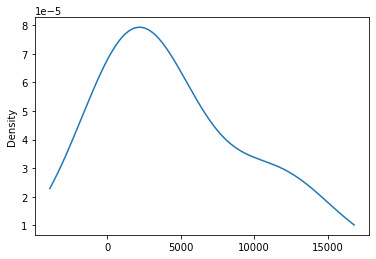

In [23]:
counts = dataset_df.employment_type.value_counts()
counts.plot.density()

## Some testing

---



## Step 4: Tockenizing

---



In [24]:
# List of columns that need to be tockenized
clean_columns = ["company_profile", "description", "requirements", "benefits"]

### NLTK 

In [25]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
def tokenize(text):
  # normalize case and remove punctuation
  text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) 
    
  # tokenize text
  tokens = word_tokenize(text)
  
  # Remove non English words  
  tokens = [w for w in tokens if w in words or not w.isalpha]

  # Remove stop words
  tokens = [w for w in tokens if w not in stopwords.words("english")]

  # lemmatize
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  # stemming
  #tokens = [stemmer.stem(word) for word in tokens]
    
  

  return tokens

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

words = set(nltk.corpus.words.words())
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# initialize count vectorizer object
vect = CountVectorizer(tokenizer=tokenize)
# initialize tf-idf transformer object
transformer = TfidfTransformer(smooth_idf=False)
# initialize tf-idf vectorizer object
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, use_idf=True, max_df=0.85, max_features=10000)

In [28]:
cleaning_df = dataset_df

#for col in clean_columns:
  # get counts of each token (word) in text data
  ##X = vect.fit_transform(cleaning_df[col])
  # use counts from count vectorizer results to compute tf-idf values
  ##tfidf = transformer.fit_transform(X)
  # compute bag of word counts and tf-idf values
  #tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize)
  #cleaning_df[f'{col}_vectorized'] = tfidf_vectorizer.fit_transform(cleaning_df[col].values)
cleaning_df['text'] = cleaning_df['company_profile'] + cleaning_df['description'] + cleaning_df['requirements'] + cleaning_df['benefits']
vectrozied_data = tfidf_vectorizer.fit_transform(cleaning_df['text'])
df1 = pd.DataFrame(vectrozied_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
res = pd.concat([cleaning_df, df1], axis=1)

KeyboardInterrupt: 

In [ ]:
df1

In [ ]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=vectrozied_data[0] 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)